#### Import various libraries:  pandas and seaborn for data wrangling and visualization json, base64, zlib, and struct for data unpacking

In [3]:
import pandas, json
from pandas import *
import base64
import zlib
import struct
import seaborn as sns

#### Import all of the Fitbit data from the big csv file. This file contains every user's Fitbit step timeseries for every available day.

In [4]:
df = DataFrame.from_csv('meas_fitbit_intraday_json_revised.csv', sep=',', index_col=0, parse_dates=True, infer_datetime_format=False)

#### Look at the first 5 rows of data. The Fitbit data are buried within the "value_json" column.

In [5]:
df.head()

,user_id,created_at,date,value_json
id,,,,
3591572,17,2015-02-09 23:33:22,2013-04-01,"{""calories"":""eJy7qJRtf3EUj+JRPIpH8SgexaN4FI/iU..."
3591573,17,2015-02-09 23:33:25,2013-04-02,"{""calories"":""eJztlzFoFEEUhiGdxEoUAnZBK4trBAMpn..."
3591574,17,2015-02-09 23:33:28,2013-04-03,"{""calories"":""eJztl69Pw1AQxwMYRM0ECcHWgOIPIISnC..."
3591575,17,2015-02-09 23:33:30,2013-04-04,"{""calories"":""eJztl69Pw1AQx1EYEuz+gEmSiUnMqmoJC..."
3591576,17,2015-02-09 23:33:33,2013-04-05,"{""calories"":""eJztliFPA0EQhUNSgkCgSFOFqEdUERLCI..."


#### Load and look at the data that contains congestive heart failure (CHF) diagnosis information for study participants.

In [7]:
df_chf = DataFrame.from_csv('chf.csv')

In [9]:
df_chf.head()

,chf,id_number
user_id,,
85,1,85
90,1,90
91,1,91
449,1,449
561,1,561


#### Group participants by diagnosis. As would be expected, the vast majority of participants (category 2) do not have CHF, while several hundred (category 1) have been diagnosed with the disorder.

In [10]:
df_chf.groupby('chf').count()

,id_number
chf,
1,641
2,11992


#### Repeating the above process, this time for chronic obstructive pulmonary disorder (COPD).

In [11]:
df_copd = DataFrame.from_csv('copd.csv')

In [13]:
df_copd.groupby('copd').count()

,id_number
copd,
1,519
2,12049


#### Now to transform the encoded/zipped Fitbit data into something that Python/pandas can work with. pandas has an "apply" method that can be called on columns within a DataFrame. The method is simply passed a function, which is then applied separately to every cell within the column.   <br><br>  Here, I define small functions (e.g. "decoder64") that are used to extract the step data from a parsed json, base 64 decode those data, decompress the decoded data, then finally unpack the result into a Python list. These functions are run serially, each creating a new column in the big df dataframe. 

In [21]:
#define functions to decode/unzip/unpack step data

def giveSteps(json_long): return json_long['steps']
def decoder64(encoded): return base64.b64decode(encoded)
def decoder_zlib(b64): return zlib.decompress(b64)
def makeStepList(steps_64_zlib):
    mylist = []
    for i in range(0,len(steps_64_zlib),2):
        holder = struct.unpack("h", steps_64_zlib[i:i+2])
        #print jim[0], "!", type(jim[0])
        mylist.extend(holder)
        #print i
    return mylist


In [23]:
#decode/unzip/unpack step data

df['json_parsed'] = df['value_json'].apply(json.loads)
df['steps_encoded'] = df.json_parsed.apply(giveSteps)
df = df.dropna()
df['steps_decoded64'] = df.steps_encoded.apply(decoder64)
df['steps_decoded64zlib'] = df.steps_decoded64.apply(decoder_zlib)
df['steps_list'] = df.steps_decoded64zlib.apply(makeStepList)


#### Now that the step list has been extracted, it's time to shift to feature engineering. This section defines various functions that each create single features from a day's time series. 

#### These first three functions extract maximum walking rates over various time windows.

In [ ]:
#Find the maximum steps/minute in a 24-hour period
def convertMax1(stepsList):
    mini = pandas.DataFrame(stepsList)
    return mini.max()

#Smooth the time series (10-minute rolling mean) then take the maximum value.
#This provides the maximum averaged steps/minute pace in 10-minute windows. 
def convertSmoothMax10(stepsList):
    mini = pandas.DataFrame(stepsList)
    miniSmooth = pandas.rolling_mean(mini, 10)
    return miniSmooth.max()

#Same as above, but looking over 60- rather than 10-minute periods
def convertSmoothMax60(stepsList):
    mini = pandas.DataFrame(stepsList)
    miniSmooth = pandas.rolling_mean(mini, 60)
    return miniSmooth.max()


#### The next three functions focus only on "active" (non-sedentary) minutes, when a participant walks at least 5 steps.

In [44]:
#Tallies the number of "active" minutes
def convertCountActive(stepsList):
    mini = pandas.DataFrame(stepsList)
    return mini[mini >= 5].count()

#Considering only those "active" minutes, finds the average rate of walking
def calcMeanActive(stepsList):
    mini = pandas.DataFrame(stepsList)
    mini = mini[mini >= 5]
    miniMeanActive = mini.mean()
    return miniMeanActive

#Like the above function, but calculates the standard deviation of active minutes
def calcStdActive(stepsList):
    mini = pandas.DataFrame(stepsList)
    mini = mini[mini >= 5]
    miniMeanActive = mini.std()
    return miniMeanActive



#### These final three functions look at autocorrelations of the time series shifted against itself by various offsets

In [ ]:
def findAutoCorr1(stepsList):
    mini = pandas.Series(stepsList)
    return mini.autocorr(1)

def findAutoCorr10(stepsList):
    mini = pandas.Series(stepsList)
    return mini.autocorr(10)

def findAutoCorr60(stepsList):
    mini = pandas.Series(stepsList)
    return mini.autocorr(60)

#### Definitions out of the way, these functions are applied to all of the time series, creating 10 new columns/features. [note: this is a very time consuming step!]

In [ ]:
df['stepTotal'] = df.steps_list.apply(sum)
df['max1'] = df.steps_list.apply(convertMax1)
df['max10'] = df.steps_list.apply(convertSmoothMax10)
df['max60'] = df.steps_list.apply(convertSmoothMax60)
df['countActive'] = df.steps_list.apply(convertCountActive)
df['meanActive'] = df.steps_list.apply(calcMeanActive)
df['stdActive'] = df.steps_list.apply(calcStdActive)
df['autocorrActive1'] = df.steps_list.apply(findAutoCorr1)
df['autocorrActive10'] = df.steps_list.apply(findAutoCorr10)
df['autocorrActive60'] = df.steps_list.apply(findAutoCorr60)

#### Some quick visualizations: histograms of the 1- and 60-minute autocorrelations. As expected, your steps/minute pace at time X is much more correlated with time X - 1 than with time X - 60!   <br><br>  That said, some of these autocorrelations look unbelievably close to 1.0, which would imply that that an individual walked at the exact same pace for every single minute of the day. 

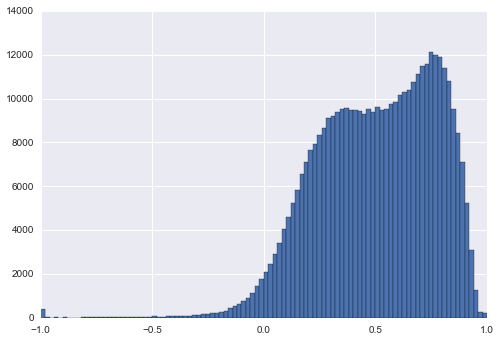

In [40]:
df.autocorrActive1.hist(bins=100)

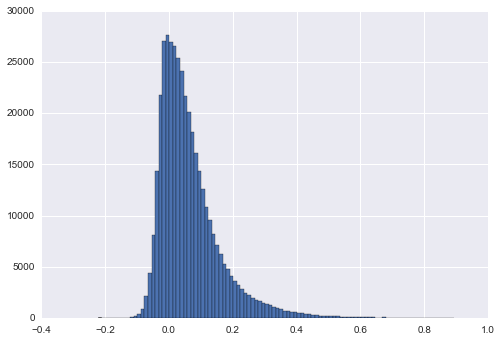

In [137]:
df.autocorrActive60.hist(bins=100)

#### Taking a descriptive look at our new features, certain extreme cases look out of whack. For example, at least one day's time series has a maximum steps/minute pace of over 8500. As Olympic sprinters have a hard time exceeding 300 steps/minute, these outlier values are clearly corrupt and need to be filtered out. 

In [48]:
df.describe()

,user_id,id_number,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,autocorrActive1,autocorrActive10,autocorrActive60
count,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403512.000000,403511.000000,403456.000000
mean,10297.229924,10297.229924,8234.849695,116.751437,81.483718,43.506493,206.016654,38.934346,29.790046,0.512057,0.282279,0.064044
std,8256.415658,8256.415658,5121.193634,48.852675,40.077718,32.882625,96.738757,14.671839,11.816080,0.251217,0.215913,0.095513
min,12.000000,12.000000,401.000000,12.000000,3.700000,1.016667,3.000000,5.648562,0.730924,-1.000000,-0.080094,-0.221888
25%,3080.000000,3080.000000,4494.000000,104.000000,48.100000,18.566667,138.000000,27.994679,21.500062,0.317745,0.106693,-0.001673
50%,7976.000000,7976.000000,7259.000000,116.000000,81.400000,32.250000,197.000000,36.128648,28.903770,0.531583,0.221085,0.041279
75%,17207.000000,17207.000000,11005.000000,126.000000,111.500000,61.816667,262.000000,47.235294,37.131799,0.726371,0.438027,0.102413
max,28734.000000,28734.000000,85965.000000,8538.000000,1968.400000,586.133333,1440.000000,387.777778,1192.362533,0.999998,0.977986,0.892457


#### A couple of quick filtering procedures: remove days with less than 400 total steps (even if those time series aren't corrupt they are very low on usable data) and days where the peak step/minute rate was greater than 325.

In [47]:
df = df[df.stepTotal > 400]

In [51]:
df = df[df.max1 < 325]

#### A quick visualization of a few of these features plotted against one another:

In [151]:
plotter = df.drop(['date_formatted','user_id','date','id_number','steps_list'],axis=1)

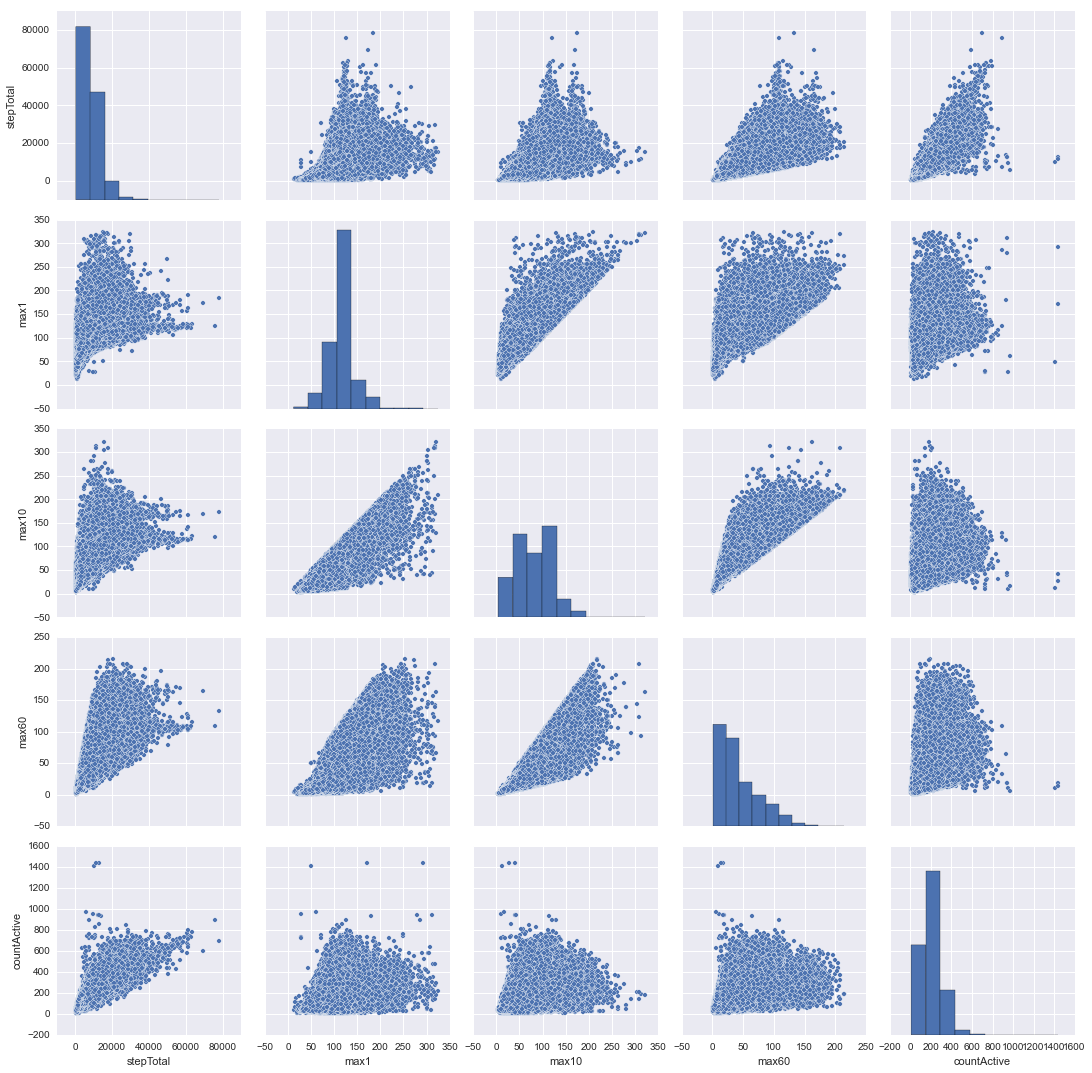

In [154]:
sns.pairplot(plotter.iloc[:,0:5])

#### The summary data look a bit better now, but, focusing on the autocorrActive1 column, we see that certain time series show essentially perfect autocorrelation or anti-autocorrelation. These are likely bad data and need to be further investigated.

In [53]:
df.describe()

,user_id,id_number,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,autocorrActive1,autocorrActive10,autocorrActive60
count,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403064.000000,403063.000000,403008.000000
mean,10295.627992,10295.627992,8226.675525,115.815803,81.257283,43.440702,205.589385,38.915542,29.713203,0.512091,0.282272,0.064051
std,8257.800738,8257.800738,5108.192308,25.897070,38.290041,32.703084,94.381216,14.565674,10.593946,0.251056,0.215850,0.095476
min,12.000000,12.000000,401.000000,12.000000,3.700000,1.016667,3.000000,5.648562,0.730924,-1.000000,-0.080094,-0.221888
25%,3080.000000,3080.000000,4492.000000,104.000000,48.100000,18.550000,138.000000,28.000000,21.494129,0.317845,0.106745,-0.001665
50%,7976.000000,7976.000000,7253.000000,116.000000,81.400000,32.233333,197.000000,36.125000,28.889681,0.531521,0.221049,0.041318
75%,17207.000000,17207.000000,11000.000000,126.000000,111.500000,61.733333,262.000000,47.220817,37.116826,0.726297,0.437923,0.102425
max,28734.000000,28734.000000,78109.000000,324.000000,321.000000,292.533333,1440.000000,262.600000,124.541326,0.992453,0.977986,0.892457


#### Here, I look at some of the most anti-autocorrelated time series and then visualize one of them.

In [56]:
df[df.autocorrActive1 < -.99].head()

,user_id,created_at,date,value_json,id_number,json_parsed,steps_encoded,steps_decoded64,steps_decoded64zlib,steps_list,...,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60
id,,,,,,,,,,,,,,,,,,,,,
3637668,1614,2015-02-13 02:23:47,2013-10-13,"{""calories"":""eJz7bdVg/xuKEx/MhNPY8G8sapGxyGY1B...",1614,{u'distance': u'eJxjYKAeePG50pqKxpEMlPXuDaj9o2...,eJxjYCAGcBKlCjcQoFD/8ALsA+2AUTBMgPBAO2DQApZROA...,x�c` p�\n7�P����Q0L��@;`��Q8\nG�( ���� ...,                                      \t      ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,19,4.0,4.000000,4,12.750000,5.678908,2013-10-13,-0.999569,0.864973,0.820715
3674465,1972,2015-02-13 08:51:34,2010-01-29,"{""calories"":""eJybWJdtP3EE4I/evA4gPNDuIBW/nWeA0...",1972,{u'distance': u'eJzt1LENgCAARFFKFpDEHZwAmYJJHE...,eJxjYBhOgGOgHTAKRhCQYRBnYBpoRww7wDQKR+EoHIWjcB...,x�c`N�c� 0\nF�ag`hG ;�4\nG�( ��pz ^��,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,28,5.3,2.000000,3,19.666667,10.408330,2010-01-29,-1.000000,0.463748,0.415051
4279857,12973,2015-02-14 09:07:06,2014-05-26,"{""calories"":""eJw7EJ1gf2AUj+JRPIpH8SgexaN4FI9iM...",12973,{u'distance': u'eJztzsEJgDAQAME87EqOtJNGhHvZgz...,eJxjYBgFo2AUjIJRMApGwVAC8/HAFQPtuFEwCrAA9oF2AJ...,x�c`�`��Q0\nF�P����Q0\n� ��v � o�\tb,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,168,159.9,39.900000,16,150.062500,38.215998,2014-05-26,-0.998275,0.327373,-0.011050
4279869,12973,2015-02-14 09:07:09,2014-05-26,"{""calories"":""eJw7EJ1gf2AUj+JRPIpH8SgexaN4FI9iM...",12973,{u'distance': u'eJztzsEJgDAQAME87EqOtJNGhHvZgz...,eJxjYBgFo2AUjIJRMApGwVAC8/HAFQPtuFEwCrAA9oF2AJ...,x�c`�`��Q0\nF�P����Q0\n� ��v � o�\tb,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,168,159.9,39.900000,16,150.062500,38.215998,2014-05-26,-0.998275,0.327373,-0.011050
4439743,9908,2015-02-17 02:39:33,2014-12-28,"{""calories"":""eJztzzENACAMADBpYGLm9k8eH/zIWJb0q...",9908,{u'distance': u'eJztzzERgDAQADAfrAhghtbCr4jqUj...,eJxjYmAahaNwFI7CUTgKR+EoHJYwjQKYM+CuH4WDEyozAA...,x�cb`��p��Q8\nG�( �0��3� ��*3  g�,                       ...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",...,108,102.6,53.766667,32,100.093750,11.925466,2014-12-28,-0.996042,0.668222,-0.023186


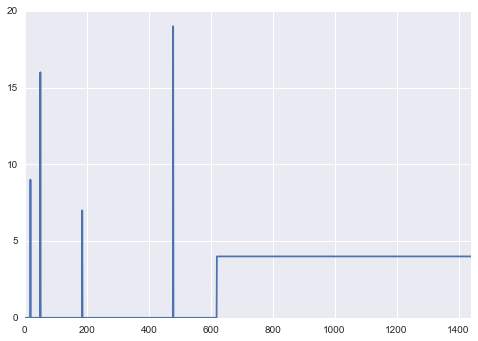

In [59]:
pandas.Series(df.loc[3637668,'steps_list']).plot()

#### These data are clearly invalid. Looking at the above histogram, which shows that most autocorrelations are greater than 0, let's conservatively filter out all data below negative 0.5. 

In [60]:
df = df[df.autocorrActive1 > -.5]

#### Now let's look at a randomly-chosen time series that just passed through this filter to see if it looks reasonable:

In [63]:
df[df.autocorrActive1 < -.49].head()

,user_id,created_at,date,value_json,id_number,json_parsed,steps_encoded,steps_decoded64,steps_decoded64zlib,steps_list,...,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60
id,,,,,,,,,,,,,,,,,,,,,
4174745,6331,2015-02-14 00:36:35,2015-01-04,"{""calories"":""eJz7tCHB/tMwxNtaNBwmXmBzWOUh6zCPR...",6331,{u'distance': u'eJxjYBie4LmWp80S8cXW0xONbbpXH7...,eJxjYKAfUGXgZ1BkEKKjjaNg6AFRYCohFbAzGOORlWHgG0...,x�c`� Pe�gPd����`�Q`*!�3㑕a�Mu�`��� ��@...,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,51,10.3,4.15,30,24.700000,12.199915,2015-01-04,-0.499203,-0.008634,0.027484
4404473,1884,2015-02-15 14:02:38,2014-09-08,"{""calories"":""eJz7IjrFXi5XwcHpfJn9KCYNfwGGHbHqY...",1884,{u'distance': u'eJxjYGBgCKhssmYYBTQFot91sYbxj6...,eJxjYOBhGGqAA4ktBCYFB8YhaIA+ruAGk7wooUAKEIfrHH...,x�c`�aj��-&�!h�>����(�@\n�� z1?�� �@;�...,                                              ...,"[0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",...,36,6.2,1.45,37,14.108108,6.288366,2014-09-08,-0.498867,0.011063,0.030321


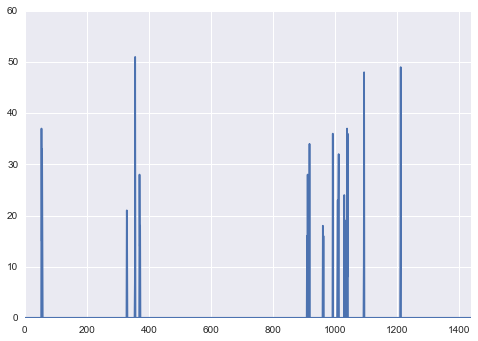

In [64]:
pandas.Series(df.loc[4174745,'steps_list']).plot()

#### This still looks a little bit strange, but an argument can be made that this a valid time series from an individual with strange walking habits.   <br><br>  Now, shifting over to the overly-high positive autocorrelations.

In [66]:
df[df.autocorrActive1 > .98]

,user_id,created_at,date,value_json,id_number,json_parsed,steps_encoded,steps_decoded64,steps_decoded64zlib,steps_list,...,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60
id,,,,,,,,,,,,,,,,,,,,,
3875943,18155,2015-02-13 15:04:36,2014-11-03,"{""calories"":""eJzt00ERABAQAMAqnloQRQoZ9DLXQxQxG...",18155,{u'distance': u'eJzt01ERABAUAEF5jAqvix76+JZBEl...,eJztwQENADAIA7BJxecNIAsZJKdtAv+oU196KQBcNmb4XDw=,x���\r 0�I��\r $�m��S_z) \6f�\<,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,200,200.0,200.000000,180,131.172222,49.272113,2014-11-03,0.990288,0.904840,0.424569
4001808,5083,2015-02-13 19:54:43,2014-09-17,"{""calories"":""eJztVz1OAkEURrTV1oQDYGNpbBmsbKxJv...",5083,{u'distance': u'eJxjYMAOtv9/aolDatiAUT8ODzDqx+...,eJztk0tPAjEQx/9l6yJRQQISPWjEs34HD9w96hHCQU4qet...,"x��KO1��e�""QA=hĳ~�=��AN*z�D��~h��l���G...",                                             ...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,140,134.2,117.716667,217,47.764977,48.038903,2014-09-17,0.980127,0.803501,-0.006746
4031943,2460,2015-02-13 20:43:24,2013-09-03,"{""calories"":""eJzt0FERABAUAMEGRgBdEEkGvYwiuojxm...",2460,{u'distance': u'eJzt1TENwCAURdE/ElJL3w8jJiqBHV...,eJxjYBgFo2AUjIJRMAqoA9zJhpED7fRRMAqoAGqpBOsH2i...,x�c`�`��Q0\n��Ɇ���Q0\n� j���#��   s�x,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,127,125.2,77.116667,67,101.119403,26.870916,2013-09-03,0.983180,0.702392,-0.047552
4059339,784,2015-02-13 21:21:41,2014-07-11,"{""calories"":""eJzt1qERgCAAQFGjmzCGEj2Klcms7mSAc...",784,{u'distance': u'eJxjYBgFo2AUjIJRMApGwSigLQg9+c...,eJxjYBgFo2AUjALSgMAoHIWjcATCYorKjX66wYMo9vYSBW...,x�c`�`�Ҁ�( ��p�b�ʍ~���(��gP�Q0�  /tI�,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,193,148.0,129.533333,584,32.297945,42.563929,2014-07-11,0.992453,0.759382,0.246237
4059859,784,2015-02-13 21:22:40,2014-08-13,"{""calories"":""eJx7Exhh/2YUj+JRPIpH8SgexaOYhtg3j...",784,{u'distance': u'eJzt0DENwCAAAEGEdGXEAShAK4jAAG...,eJxjYBgFo2AUjALSgBvNYe5Ae3EUjIJRQGUwmy5wwUB7cx...,x�c`�`�Ҁ�a�@{q��Q@e0�.p�@{s�  �l-U,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,160,155.5,134.416667,102,113.764706,42.534826,2014-08-13,0.990088,0.791082,-0.069434
4139565,22391,2015-02-13 23:33:13,2014-01-05,"{""calories"":""eJztVjtOA0EMFRINBZFScIUVSh0hpcpQb...",22391,{u'distance': u'eJxjYBg8QDj6s+VAuwEGRt2CGwwm94...,eJztlE0OgjAQhV+LiLL0Iro04TKSSBH1/muHSWlpg1KTkt...,"x��M�0�_����""�4�2�H��k�Iii�R��ԟ~y3M�L��1�׹...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,108,107.2,103.766667,120,59.558333,46.091760,2014-01-05,0.983292,0.872309,0.053450
4210424,22391,2015-02-14 02:24:22,2014-04-27,"{""calories"":""eJwzEVxmbzKKR/EoHsWjeBSP4lE8ikfxK...",22391,{u'distance': u'eJxjYBgFo2AUjIJRMApGwSgYBaNgFI...,eJztkt2OwUAYhl9lSylxIIjqXom9IyvET0gEiYSEI2IlXK...,x��ݎ�@�_eK)q ��^��#+�OH���#b%\��g��p�G�}�|�...,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,154,147.6,132.000000,213,52.807512,56.633675,2014-04-27,0.985332,0.867068,0.196442
4210429,22391,2015-02-14 02:24:23,2014-04-28,"{""calories"":""eJzlWL9LHEEUbmxSWqRIYWHhFhbR4rCKu...",22391,{u'distance': u'eJxjYEAA4ejPlgw0BLQ0fyi7faibP5...,eJztVU1PwkAQfa2lEAMmiiTUC968iPHjd+hBfgL/AuPNi1...,x��UMO�@}��&�$� ޼���w�A~��͋WQ���7.����[v...,                                             ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,173,172.0,147.883333,244,52.995902,56.964612,2014-04-28,0.983089,0.829325,-0.043065
4277589,21236,2015-02-14 08:57:20,2015-01-02,"{""calories"":""eJzt0KEVQBEAAMAxjINpdO8H1R4WM4siy...",21236,{u'distance': u'eJzt1DEVwCAQRMFr0RINZwcH6RINKd...,eJxjYBgFo2AUjIJRMApwgYkUw1UD7YVRQAVwkCrw0EB7Yx...,x�c

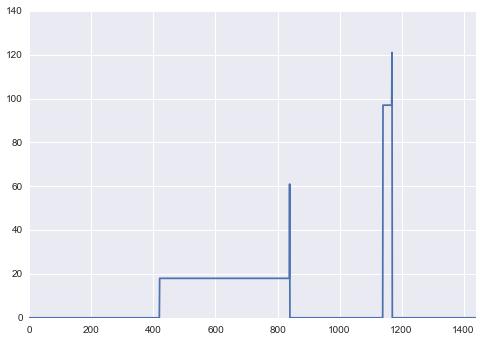

In [70]:
pandas.Series(df.loc[5024923,'steps_list']).plot()

#### Just as with the extreme negative autocorrelations, this time series is clearly garbage. Another quick look at the autocorrelation histogram from above:

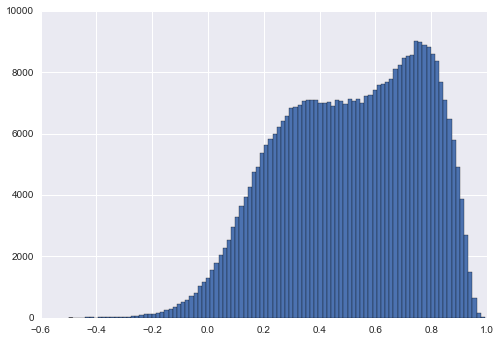

In [69]:
df.autocorrActive1.hist(bins=100)

#### Somewhat arbitrarily, I am setting a threshold of 0.95. Those values close to 1.0 are very suspect, but I also don't want to start removing large chunks of valid (albeit atypical) data. I then look at the histogram of one of the time series that just missed being filtered out.

In [71]:
df = df[df.autocorrActive1 < .95]

In [72]:
df[df.autocorrActive1 > .94]

,user_id,created_at,date,value_json,id_number,json_parsed,steps_encoded,steps_decoded64,steps_decoded64zlib,steps_list,...,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60
id,,,,,,,,,,,,,,,,,,,,,
3591696,558,2015-02-09 23:37:47,2013-09-12,"{""calories"":""eJxb/e6d/WoysYPgxAHBHgE2NMMffibS1...",558,{u'distance': u'eJztV0FrE0EUXkQExULJpaAIEcmlHg...,eJztVUlPwkAYfTVY2gKlrJbKogIG44IGNTHRkzGePBhP3o...,x��UIO�@}5X����ʢ�51ѓ1�<Oތ7=�͓�7�N�P�A...,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,303,276.9,177.200000,287,55.839721,84.635554,2013-09-12,0.945876,0.726229,-0.018936
3595511,1184,2015-02-10 04:11:58,2014-03-06,"{""calories"":""eJztVytPA0EQTqqwDQqBx5AQ6khI11XVo...",1184,{u'distance': u'eJztl89LVUEUx4XASFr0iEJyYWBE9s...,eJztVU1PAjEUHCPs8s2KgiIYowmJGhNjYjzqxYMHEw/Ggz...,"x��UMO1 #��͊�""�\t�cb<�Ńƃ7?�AQ����� ^w�...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,121,119.2,84.500000,250,47.936000,46.541642,2014-03-06,0.940478,0.740084,-0.054200
3599872,12,2015-02-10 12:01:12,2015-02-07,"{""calories"":""eJztV79rVEEQrlIohxaSRgvPgAThooUgh...",12,{u'distance': u'eJztlm9o1WUUx2e+sJEZ/blmTYnkUp...,eJztlN9LFFEUx7/qujPrzlq2q672gzQtFfuBYkSBWD1Fb4...,"x���KQǿ�3��Z�����4-��bD�X=Eo�E=�""*�� ���� ...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,167,163.4,155.600000,462,66.937229,63.519160,2015-02-07,0.940644,0.770496,0.136667
3613179,16,2015-02-11 11:02:27,2014-08-23,"{""calories"":""eJztVr1KA0EQri4P4BME+3SpAuHOziqdY...",16,{u'distance': u'eJztVj1Iw0AULh3c7GQmxUGEQp3cTH...,eJztVclOwzAQfXXirK2gLE3hAAjUcuDAIhUVJPj/z2K8Zu...,"x��U�N�0}u⬭�,M� �r��""$���b�f�:!TH ����}��...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,62,57.3,26.133333,311,16.016077,14.851840,2014-08-23,0.944049,0.528377,0.078720
3624322,1884,2015-02-12 20:11:29,2011-08-07,"{""calories"":""eJztWL9Lw0AU/gsyCoI6iIsguHXRwcNJd...",1884,{u'distance': u'eJxjYBgFgwlkTj1nzfGS3QbEDqhksr...,eJxjYBgeQJhBEkhKMIgw8OJVJwqEo2AU0AdIDrQDRgGDAA...,x�c` @�AHJ0�0��U'\n��`�H�F� 3^ys���� =...,                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,108,105.1,87.783333,97,64.350515,41.555445,2011-08-07,0.940884,0.860127,0.019365
3625038,567,2015-02-12 20:32:10,2013-06-06,"{""calories"":""eJztVrtKBEEQFM085PARH06qgT8gOhsoI...",567,{u'distance': u'eJztl01IVFEUx4XQWogJQSTRUiSohd...,eJzlVdtOwkAQPSaFUqDcoa0XFIiIolFMeDEx4Umf/CKf/A...,"x��U�N�@=&�R�ܡ����QLx11�I��""��Ml��t��m�K ...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,164,162.9,159.633333,264,53.496212,59.955243,2013-06-06,0.944644,0.806086,0.003354
3625572,134,2015-02-12 20:46:29,2012-06-09,"{""calories"":""eJzdmD1oFEEUx/0oBAVTpBHOQkSCAcE0B...",134,{u'distance': u'eJztWF9IlEEQF0UDkwSFDIMirSeFHi...,eJzVVs1PE1EQ/4mytbTUlqIWsigoRFQw4YQHExMP3DlqjQ...,"x��V�OQ�����Ԗ��((DT0��9j�\tF"" ��ݭ^<iЛ...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,167,163.0,147.783333,357,84.042017,53.161836,2012-06-09,0.947687,0.818253,0.129138
3628648,1705,2015-02-12 22:09:45,2012-02-18,"{""calories"":""eJztVr9LHEEUziUaIkGRBEIgpA4XTGFlI...",1705,{u'distance': u'eJztV19IU2EUN6KENClJCMkHUSSJRs...,eJztVEsvQ0EU/hZcbfWpD9WUehQNyqJBPCKxwC/QWEsEO7...,"x��TK/CA�\m��Քz\rʢA<""��/�XK;�!����X� 6*U...",                                              ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,176,167.3,161.400000,228,72.530702,64.151761,2012-02-18,0.941323,0.837586,0.221709
3628913,3316,2015-02-12 22:17:11,2012-05-16,"{""calories"":""eJztWL1KA0EQjiDY+wCCrSjYiAgGN1gq2...",3316,{u'distance': u'eJxjYBge4MAHARuSNQnVWNPAKaSBFZ...,eJzlVU1PwkAQfYpWbQu2INHYcPFAYrxoYkwvnPwR

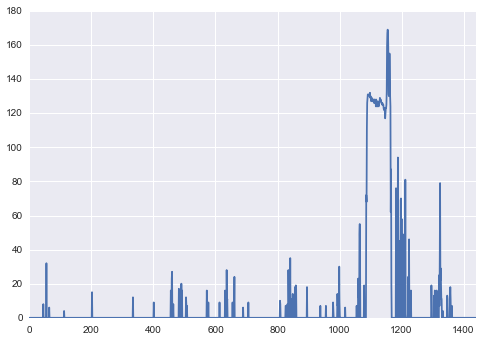

In [76]:
pandas.Series(df.loc[3628948,'steps_list']).plot()

#### Passes the sanity check, at least to my eyes. 

#### As the next steps are to merge the Fitbit and clincal data sets, a little bit of cleanup is in order. Here, I drop the columns that hold the encoded versions of the time series: they are no longer useful.

In [77]:
df.drop('created_at', axis=1, inplace=True)
df.drop('value_json', axis=1, inplace=True)
df.drop('json_parsed', axis=1, inplace=True)
df.drop('steps_encoded', axis=1, inplace=True)
df.drop('steps_decoded64', axis=1, inplace=True)
df.drop('steps_decoded64zlib', axis=1, inplace=True)
df.head()

,user_id,date,id_number,steps_list,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60
id,,,,,,,,,,,,,,,
3591573,17,2013-04-02,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",23027,135,125.5,120.150000,280,82.210714,46.145887,2013-04-02,0.784580,0.538330,0.082339
3591574,17,2013-04-03,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15947,129,123.9,71.400000,206,77.383495,43.702581,2013-04-03,0.723652,0.494631,-0.035471
3591575,17,2013-04-04,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14242,126,122.5,119.833333,183,77.814208,46.393544,2013-04-04,0.799999,0.690751,0.127270
3591576,17,2013-04-05,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21278,138,123.5,121.633333,224,94.973214,40.670382,2013-04-05,0.763572,0.627236,0.043276
3591577,17,2013-04-06,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14311,127,118.7,114.266667,234,61.141026,43.420014,2013-04-06,0.813073,0.606886,0.098786


#### First, a couple of histograms of (a) all participants and (b) one randomly selected participant, depicting daily step count totals. The smoothness of the full cohort distribution is interrupted by small peaks at around 10- and 20-thousand steps. These are likely driven by Fitbit’s goal-setting feature: a user can choose a certain target number of daily steps (the default is 10,000) and is given updates throughout the day about how far they’ve gone toward reaching that goal. It looks like this method actually works to promote physical activity!

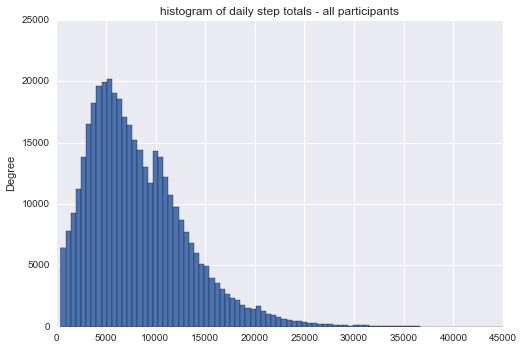

In [80]:
df.stepTotal.plot(kind='hist', bins=150, xlim=[0,45000], title='histogram of daily step totals - all participants')

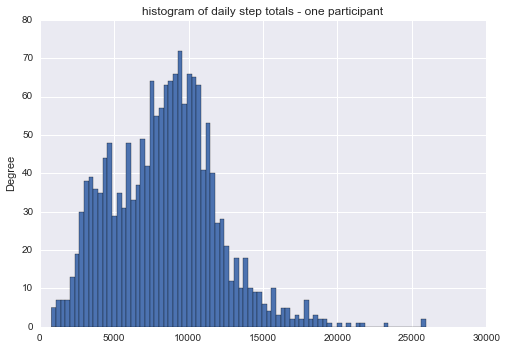

In [82]:
df[df.user_id == 315].stepTotal.plot(kind='hist', bins=80, xlim=[0,30000], title='histogram of daily step totals - one participant')

#### The primary analysis I will perform below looks at linking together Fitbit data with daily symptom reports pertaining to <b> shortness of breath </b>. Shortness of breath is one of the strongest indicators of cardiovascular problems (including CHF and COPD). First, I'll load the data and look at how many data points we have for each “shortness” rating, where 1 = no symptoms and 5 = severe symptoms.

In [83]:
shortness = pandas.read_csv('../../ginger/meas_ginger_surveys_shortness.csv',sep=',',index_col='user_id',parse_dates=['date_plus1'], dayfirst=True)

In [84]:
shortness.head()

,score,date_plus1
user_id,,
58,1,2015-07-15
58,1,2015-07-01
58,1,2015-06-29
58,1,2015-06-29
58,1,2015-06-23


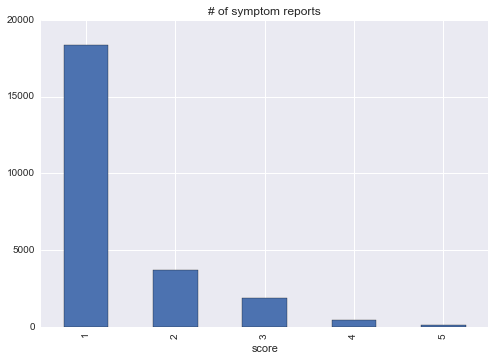

In [85]:
shortness.groupby('score').count().plot(kind='bar', legend=False, title='# of symptom reports')

#### There looks to be somewhere in the neighborhood of 25000 days of symptom report data. That said, many of those days will not be linkable to Fitbit data. <br><br> Next, the daily symptom data has to be matched with Fitbit data from the exact same days. The symtom survey actually asks participants how they felt -yesterday-. Thus, the date labels for shortness of breath all have to be shifted one day into the past ("timedelta"). 

In [86]:
import datetime as dt
shortness['date_formatted'] = shortness.date_plus1.apply(lambda x: x - dt.timedelta(days=1))

In [87]:
shortness['user_id'] = shortness.index

In [34]:
df['date_formatted'] = to_datetime(df.date)

#### This next step performs a SQL-like inner join on the two datasets. Only those rows (i.e. specific day/participant combinations) for which we have both Fitbit and shortness data are allowed into this new dataframe, called "merged."

In [88]:
merged = pandas.merge(df, shortness, on=['user_id','date_formatted'])

#### As expected, only a minority of the symptom report data also has Fitbit data linkable to it. From ~25000 days of shortness of breath reports, we now have less than 6000. However, that should still be plenty for our machine learning algorithm to make use of.

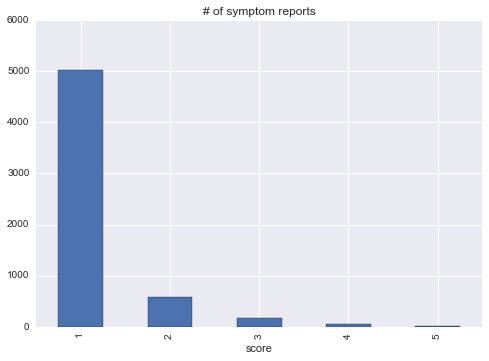

In [89]:
merged[['max1','score']].groupby('score').count().plot(kind='bar', legend=False, title='# of symptom reports')

In [90]:
merged.head()

,user_id,date,id_number,steps_list,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60,score,date_plus1
0,3650,2013-10-18,3650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 61, 0, 0...",17953,116,107.7,45.100000,352,50.914773,36.275593,2013-10-18,0.665320,0.384630,-0.002350,1,2013-10-19
1,3650,2013-10-18,3650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61, 61, 0, 0...",17953,116,107.7,45.100000,352,50.914773,36.275593,2013-10-18,0.665320,0.384630,-0.002350,1,2013-10-19
2,3650,2013-10-19,3650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12140,125,84.6,48.516667,318,38.169811,25.081371,2013-10-19,0.372130,0.444384,0.301038,1,2013-10-20
3,3650,2013-10-20,3650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18371,115,99.6,51.366667,441,41.560091,25.905714,2013-10-20,0.503694,0.460284,0.297038,1,2013-10-21
4,3650,2013-10-21,3650,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16524,118,111.5,42.433333,322,51.239130,35.899938,2013-10-21,0.713318,0.297573,0.044012,1,2013-10-22


#### A quick check to see exactly how many rows (days) of data exist for each symptom level.

In [91]:
merged[['max1','score']].groupby('score').count()

,max1
score,
1,5012
2,578
3,170
4,46
5,14


#### The goal for this present analysis is to use the Fitbit data to decode symptom level. To keep things simple, I will look at scores of 1 (no symptoms) vs. all of the other levels lumped together (moderate to severe symptoms). 

In [92]:
def symptomBinarize(score):
    if score > 1: return 2
    else: return 1

In [93]:
merged['score_12'] = merged.score.apply(symptomBinarize)
merged.describe()

,user_id,id_number,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,autocorrActive1,autocorrActive10,autocorrActive60,score,score_12
count,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5820.000000,5819.000000,5820.000000,5820.000000
mean,5362.606357,5362.606357,8059.719588,110.847251,78.459416,43.816853,203.078866,38.148789,29.166080,0.514996,0.300330,0.066467,1.191065,1.138832
std,6309.755039,6309.755039,5348.405238,28.109302,39.543475,34.321126,106.101994,13.464960,10.536917,0.268189,0.228836,0.094565,0.537882,0.345800
min,113.000000,113.000000,414.000000,23.000000,4.600000,1.233333,13.000000,10.634146,5.018745,-0.498867,-0.041829,-0.129918,1.000000,1.000000
25%,906.000000,906.000000,3814.000000,98.000000,43.500000,17.333333,116.000000,28.102421,21.407306,0.293025,0.110004,0.000207,1.000000,1.000000
50%,2150.000000,2150.000000,6861.000000,109.500000,81.100000,31.750000,199.000000,36.580460,28.484608,0.558233,0.241071,0.045328,1.000000,1.000000
75%,7685.000000,7685.000000,11565.250000,121.000000,107.200000,67.291667,276.000000,47.389814,36.601427,0.750717,0.465682,0.109039,1.000000,1.000000
max,27993.000000,27993.000000,40372.000000,317.000000,308.900000,185.833333,603.000000,178.531250,107.640785,0.949915,0.915606,0.651060,5.000000,2.000000


In [95]:
merged.groupby('score_12').count()

,user_id,date,id_number,steps_list,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,date_formatted,autocorrActive1,autocorrActive10,autocorrActive60,score,date_plus1
score_12,,,,,,,,,,,,,,,,,
1,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012,5012
2,808,808,808,808,808,808,808,808,808,808,808,808,808,808,807,808,808


#### This leaves me with 808 in the "have symptoms" group. As the two groups are very unbalanced, I will downsample the larger one to end up with two equal-sized groups of 808 rows each. 

In [96]:
group1 = merged[merged.score_12 == 1].sample(808)

In [102]:
group2 = merged[merged.score_12 == 2]

In [108]:
group12balanced = pandas.concat([group1,group2])

In [109]:
group12balanced.describe()

,user_id,id_number,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,autocorrActive1,autocorrActive10,autocorrActive60,score,score_12
count,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1615.000000,1616.000000,1616.000000
mean,7333.178837,7333.178837,7824.445545,109.347772,75.052042,39.820163,210.308168,36.340012,27.935452,0.492018,0.276995,0.067821,1.688119,1.500000
std,7164.530105,7164.530105,5133.105745,25.583694,37.653347,31.371625,113.735200,12.388412,9.892130,0.261546,0.215181,0.092188,0.836775,0.500155
min,113.000000,113.000000,422.000000,26.000000,4.900000,1.566667,14.000000,11.948718,6.316014,-0.304138,-0.024791,-0.101745,1.000000,1.000000
25%,1297.000000,1297.000000,3786.000000,96.000000,42.900000,17.191667,116.000000,26.878561,20.522124,0.274754,0.106762,0.003696,1.000000,1.000000
50%,4358.000000,4358.000000,6558.000000,107.000000,71.350000,29.008333,200.000000,34.306788,26.646509,0.500094,0.220173,0.048310,1.500000,1.500000
75%,11844.000000,11844.000000,11166.000000,118.000000,103.525000,51.683333,288.000000,44.409161,34.486272,0.725979,0.402033,0.107816,2.000000,2.000000
max,27993.000000,27993.000000,26509.000000,252.000000,216.000000,162.933333,602.000000,101.805556,67.760249,0.949683,0.915606,0.626417,5.000000,2.000000


#### Preparing for the machine learning analyses with scikit-learn, I drop no longer useful columns (e.g. date) plus stray rwos with null values ("na") that will crash the classification algorithm. 

In [116]:
group12balanced.drop('date_formatted', axis=1, inplace=True)

In [126]:
group12balanced.describe()

,user_id,id_number,stepTotal,max1,max10,max60,countActive,meanActive,stdActive,autocorrActive1,autocorrActive10,autocorrActive60,score,score_12
count,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000,1615.000000
mean,7336.388235,7336.388235,7828.636533,109.350464,75.069783,39.833922,210.422910,36.336358,27.933526,0.492169,0.276903,0.067821,1.687926,1.499690
std,7165.587164,7165.587164,5131.929277,25.591390,37.658253,31.376465,113.676829,12.391378,9.894891,0.261556,0.215216,0.092188,0.836999,0.500155
min,113.000000,113.000000,422.000000,26.000000,4.900000,1.566667,14.000000,11.948718,6.316014,-0.304138,-0.024791,-0.101745,1.000000,1.000000
25%,1297.000000,1297.000000,3787.000000,96.000000,42.900000,17.183333,116.500000,26.878461,20.507824,0.275431,0.106629,0.003696,1.000000,1.000000
50%,4358.000000,4358.000000,6559.000000,107.000000,71.400000,29.016667,200.000000,34.301075,26.645047,0.500526,0.219540,0.048310,1.000000,1.000000
75%,11844.000000,11844.000000,11166.000000,118.000000,103.550000,51.683333,288.000000,44.414381,34.498983,0.726130,0.401852,0.107816,2.000000,2.000000
max,27993.000000,27993.000000,26509.000000,252.000000,216.000000,162.933333,602.000000,101.805556,67.760249,0.949683,0.915606,0.626417,5.000000,2.000000


In [125]:
group12balanced = group12balanced.dropna()

#### The variable X is set as a numpy array containing all the extracted Fitbit data that will be used to predict symptom reports. The variable y is set to be the symptom report scores (1 = no symptoms, 2 = symptoms). 

In [127]:
X = group12balanced.iloc[:,2:-2].values

In [129]:
y = ravel(group12balanced.loc[:,'score_12'].values)

#### From scikit-learn, I import the machine learning classification algorithm (random forest) and a method for performing cross validation. 

In [130]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier


#### Performing 8-fold cross validation yields a testing accuracy of 68%, well above chance level (which, with our balanced classes, is 50%). 

In [131]:
scores = cross_val_score(RandomForestClassifier(n_estimators=150), X, y, scoring='accuracy', cv=8)
print scores
print scores.mean()

[ 0.72277228  0.7029703   0.6980198   0.65841584  0.66831683  0.66831683
  0.65346535  0.66169154]
0.679246096251


#### To make sure that 68% is "good" in the statistical sense, I run a permutation test, scrambling the symptom labels of the data in each row. Essentially, the classifier is now trying to predict noise, so this step, via 1000 permutations, should generate a null distribution centered on approximately 50%. 

In [144]:
import sklearn.cross_validation

In [146]:
permutation_test = sklearn.cross_validation.permutation_test_score(RandomForestClassifier(n_estimators=150), X, 
                                                         y, scoring='accuracy', cv=8, n_permutations=1000, n_jobs=4)
permutation_test

(0.67553322496428736,
 array([ 0.47244902,  0.51268103,  0.50898663,  0.50404537,  0.52070403,
        0.4823654 ,  0.5102027 ,  0.50899586,  0.50650214,  0.48420029,
        0.5151963 ,  0.52323777,  0.49718918,  0.51082767,  0.48484065,
        0.50835858,  0.48604441,  0.48359071,  0.49845143,  0.47987784,
        0.52197244,  0.49225408,  0.49660423,  0.47428082,  0.48791008,
        0.50093591,  0.51082459,  0.49908871,  0.50281698,  0.4891631 ,
        0.50648675,  0.50028939,  0.49534506,  0.48546562,  0.49226947,
        0.48981577,  0.5021643 ,  0.48425878,  0.52322546,  0.46567595,
        0.48853813,  0.51701579,  0.50897123,  0.51827496,  0.49536045,
        0.51392481,  0.49908256,  0.49535737,  0.4786279 ,  0.50465494,
        0.51146803,  0.5083555 ,  0.5089897 ,  0.52445384,  0.4891631 ,
        0.5126841 ,  0.48605672,  0.49972908,  0.51579664,  0.5059018 ,
        0.47062029,  0.49041919,  0.47492119,  0.50340808,  0.50031095,
        0.49471085,  0.53807694,  0.48793

In [149]:
print "The average scrambled permutation accuracy: " + str(permutation_test[1].mean())
print "The observed accuracy with real labels: " + str(permutation_test[0])
print "p-value: " + str(permutation_test[2])

The average scrambled permutation accuracy: 0.498402729545
The observed accuracy with real labels: 0.675533224964
p-value: 0.000999000999001


#### Finally, a quick analysis to look at feature importances. No features seem to truly dominate and the error bars are large, so this result should be taken with a grain of salt. The features that seem to be the most important have to do with pace and variability of active minutes, as well as 10-minute shifted autocorrelations. The latter is perhaps an interesting finding, as capacity for sustained walking over a several minute period is sometimes performed by doctors as an in-office screen for CHF. 

Feature ranking:
1. feature 5 (0.112182)
2. feature 6 (0.110326)
3. feature 8 (0.106172)
4. feature 7 (0.099638)
5. feature 2 (0.099110)
6. feature 4 (0.098212)
7. feature 3 (0.097846)
8. feature 0 (0.097497)
9. feature 9 (0.094113)
10. feature 1 (0.084904)


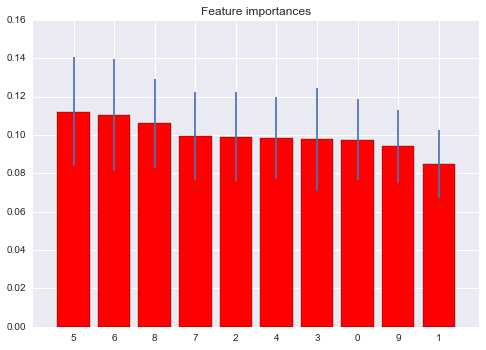

In [138]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=150)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()